# Void Clustering

We will firstly import libraries and generate our test sample to evaluate our cluster.

In [186]:
import sklearn
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import scipy
from scipy.spatial import distance
from scipy.optimize import minimize

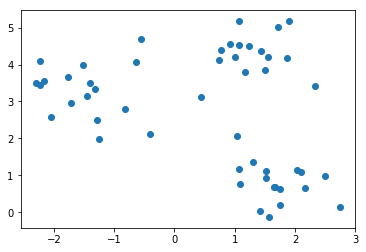

[[1.54632313 4.212973  ]
 [1.67467427 0.68001896]
 [1.24258802 4.50399192]]


In [105]:
X, y = make_blobs(n_samples=50, centers=3, n_features=2, cluster_std=0.6, random_state=0)

plt.scatter(X[:, 0], X[:, 1])
plt.show()

print(X[:3, :])

In [106]:
def display_initial(data):
    """
    Args:
        data (array) :
    """
    plt.scatter(data[:, 0], data[:, 1])
    plt.title("Initial data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

## Naive Optimization Method

In [151]:
def naive_cost(x, data, metric, epsilon=1e-10):
    """
    Args:
        x (array): array of size n
        data (array): shape (D, n) with D the number of points in the data
    Return:
        cost (float) : cost to minimize
    """
    distances_vector = distance.cdist([x], data, metric=metric)
    smallest_distance = np.min(distances_vector)
    cost = - np.log(smallest_distance+epsilon)
    return cost

## Algorithm v1

In [237]:
def generate_next_point(data, metric, nb_simulations, std_coef):
    """
    Args
        data (array): initial data to perform the clustering on
        nb_simulations (int) : number of simulation to create next point and select the best one
        std_coef (float) : multiply to std to determine the sample zone
    
    Return:
        res.x (array): next point
        res.fun (array): next smallest distance
    """
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    bounds = ((data_mean[0]-std_coef*data_std[0], data_mean[0]+std_coef*data_std[0]), 
                (data_mean[1]-std_coef*data_std[1], data_mean[1]+std_coef*data_std[1]))
    store_tmp_points = np.zeros((nb_simulations,2))
    store_tmp_distances = np.zeros(nb_simulations)
    
    for i in range(nb_simulations):
        # generate a smart initial random position
        x0 = data_mean + std_coef * data_std @ np.array([np.random.random(), np.random.random()]).T
        res = minimize(fun=naive_cost, x0=x0, args=(data, metric), bounds=bounds)
        # store the current optimal point and distance for this particular random initial condition
        store_tmp_distances[i] = res.fun
        store_tmp_points[i] = res.x
    
    # select the -best optimal one- from the optimal points
    idx_opt = np.argmin(store_tmp_distances)
    
    return store_tmp_points[idx_opt], np.exp(-store_tmp_distances[idx_opt])

In [216]:
def display_points(data, list_points, list_lines, iteration):
    """
    Display all the points and the - clustering points - in another color to recognize them better.
    
    Args:
        data (array): initial data to perform the clustering on
        list_points (array): list of new points added where the last one is the brand new one
    """
    # disp the initial data points
    plt.scatter(data[:, 0], data[:, 1], c="black")
    
    # disp the added points (void cluster points)
    list_points = np.array(list_points)
    plt.scatter(list_points[:, 0], list_points[:, 1], c='red', s=0.1)
    
    # disp the lines
    for segment in list_lines:
        plt.plot([segment[0][0], segment[1][0]], [segment[0][1], segment[1][1]], c='red')
    
    plt.title("Iteration n°" + str(iteration) + " void cluster point")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [235]:
def count_point_apparitions_in_segments(point, segments):
    """
    Args:
    
    Return:
        nb_apparitions (int) : number of time the point appears as an extremity of a segment
    """
    segments = np.array(segments)
    nb_apparitions = 0
    for segment in segments:
        for pt in segment:
            if np.array_equal(pt, point):
                nb_apparitions += 1
                break
    return nb_apparitions

In [252]:
def update_lines(list_points, list_lines, limit_dist, limit_point_nb_apparitions, metric):
    """
    Args:
    
    Return:
        list_lines (list): updated list of geometric lines to defining the clustering
    """
    last_point = list_points[-1]
    other_points = np.array(list_points)[:-1, :]
    
    # get added points that are close to the last added point
    distances_vector = distance.cdist([last_point], other_points, metric=metric)[0]
    idx_condition = np.where(distances_vector < limit_dist)
    matching_points = other_points[idx_condition]
    
    # add lines to the lines list
    for point in matching_points:
        if count_point_apparitions_in_segments(point=point, segments=list_lines) <= limit_point_nb_apparitions:
            list_lines.append([point, last_point])
    return list_lines

In [279]:
def void_clustering(data, 
                    alpha=0.2, 
                    nb_simulations=5,
                    limit_point_nb_apparitions=2,
                    metric='euclidean',
                    std_coef=0.9):
    """
    Args
        data (array) : data to find the cluster
    """
    display_initial(data=data)

    # initialization
    list_dists = []
    list_points = []
    list_lines = []
    cur_d = 0
    i = 0
    
    while cur_d == 0 or cur_d >= alpha*init_dist:
        # compute next point and distance from its closest point
        next_point, next_dist = generate_next_point(data=data, 
                                                    metric=metric, 
                                                    nb_simulations=nb_simulations,
                                                    std_coef=std_coef)
        
        # in case first loop OR new distance stricly smaller than previous distance
        if cur_d == 0: #or next_dist < cur_d:
            init_dist = next_dist
            print("d(0)=", init_dist)
    
        # update variables
        i += 1
        cur_d = next_dist
        list_dists.append(cur_d)
        list_points.append(next_point)
        data = np.append(data, [next_point], axis=0)
        
        # updates lines to make the clustering (at least second loop)
        if i != 1:
            list_lines = update_lines(list_points, 
                                      list_lines, 
                                      limit_dist=init_dist, 
                                      limit_point_nb_apparitions=limit_point_nb_apparitions,
                                      metric=metric)

        # display the points
        if i % 1 == 0:
            display_points(data[:-i,:], list_points, list_lines, iteration=i)

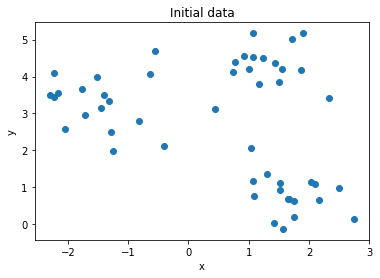

d(0)= 0.9716998125019944


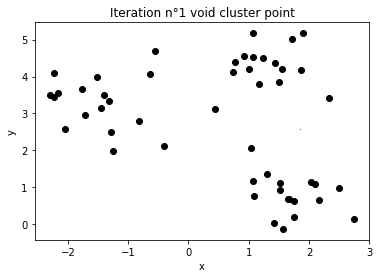

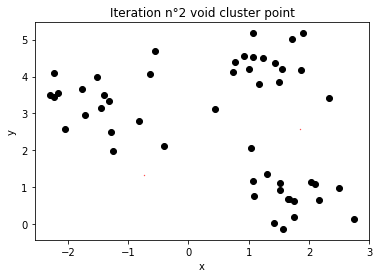

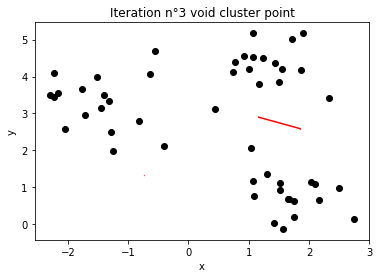

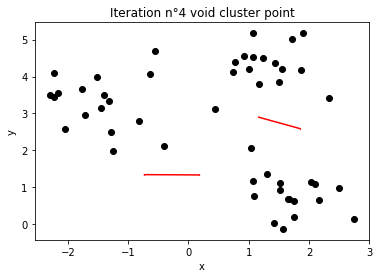

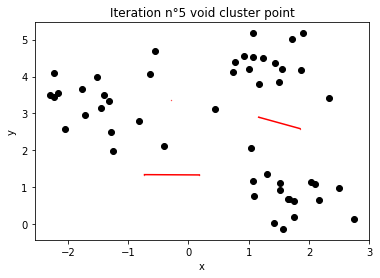

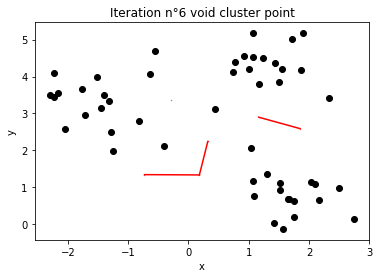

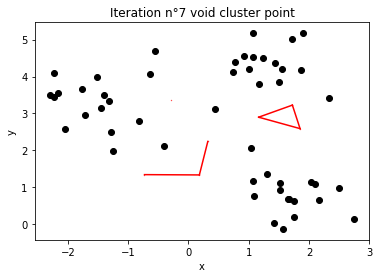

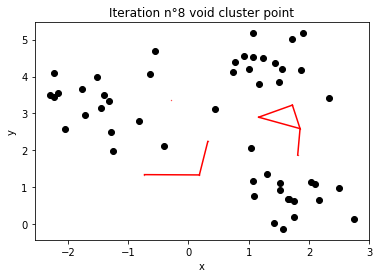

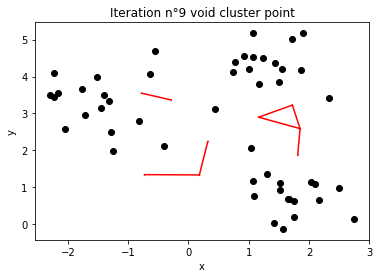

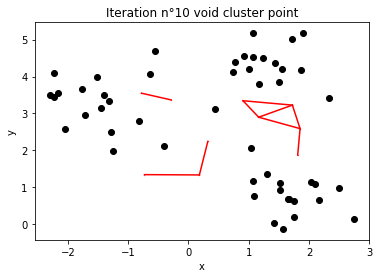

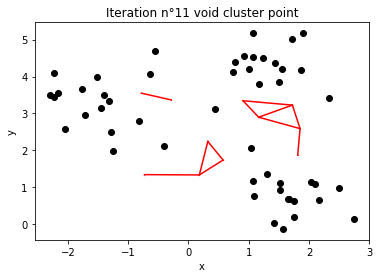

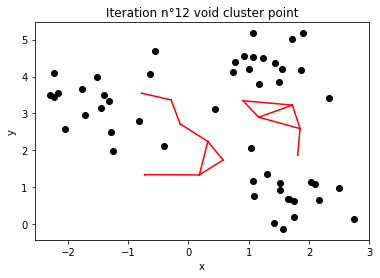

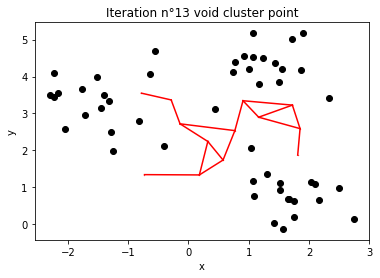

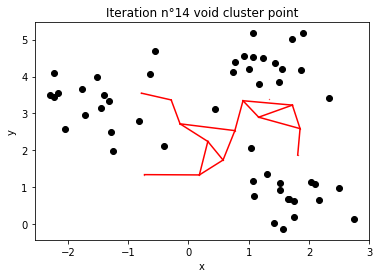

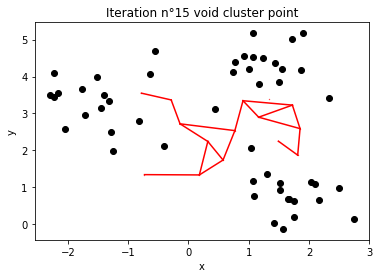

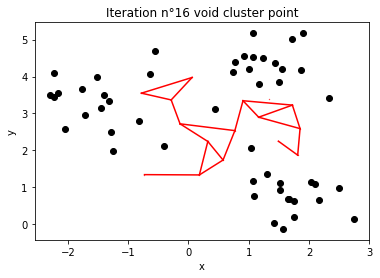

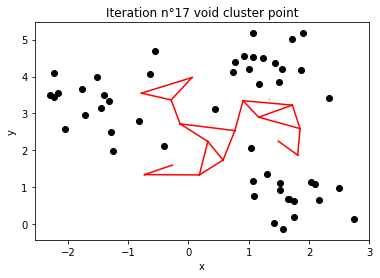

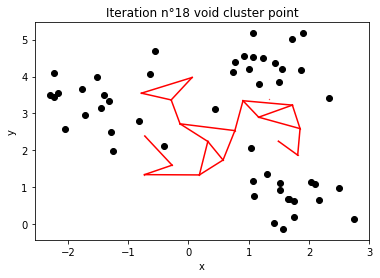

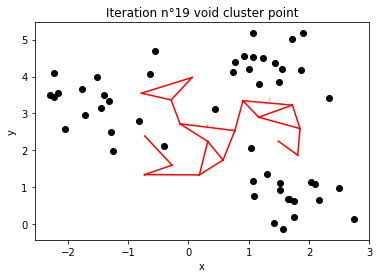

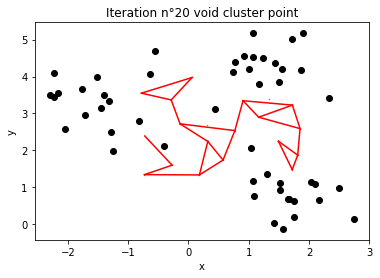

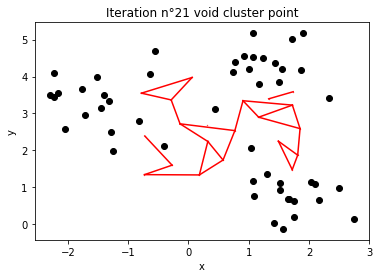

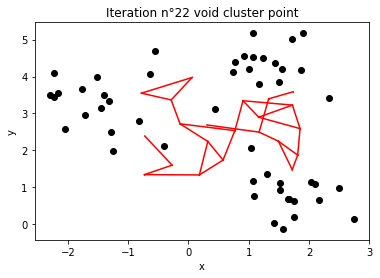

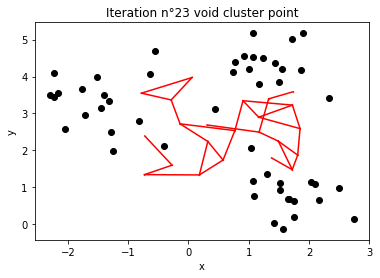

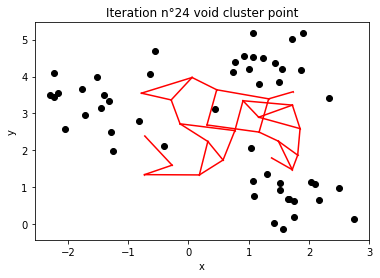

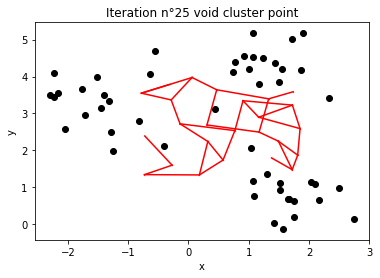

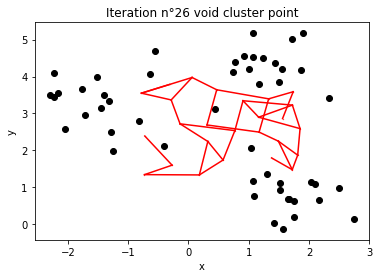

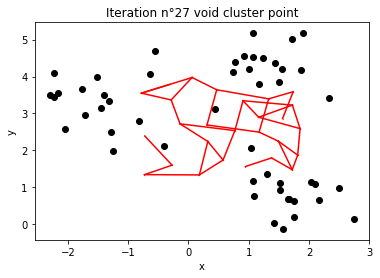

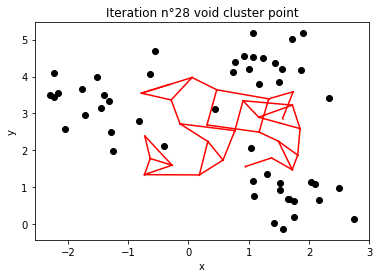

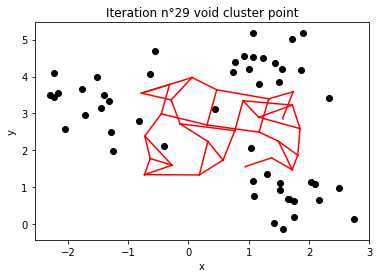

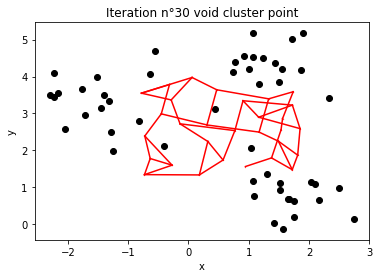

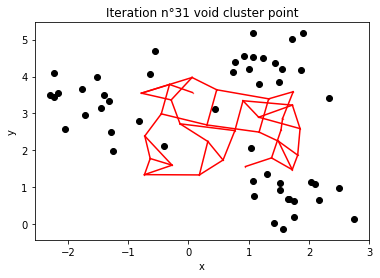

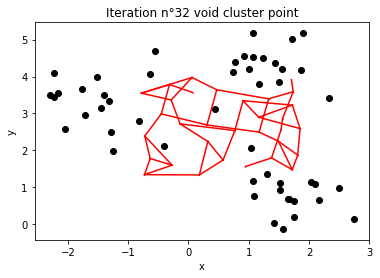

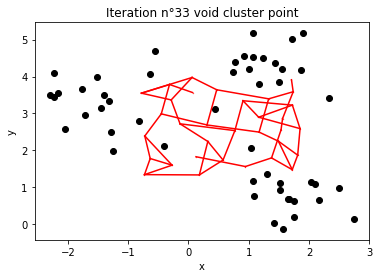

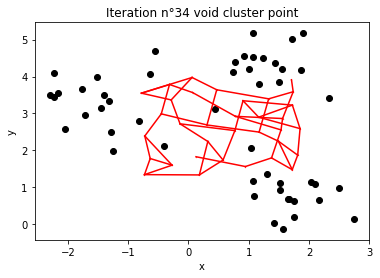

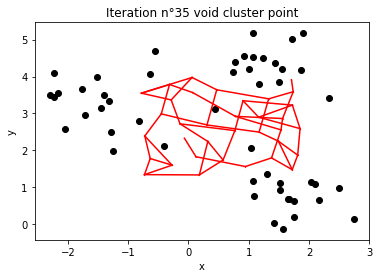

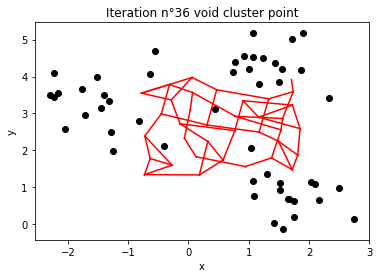

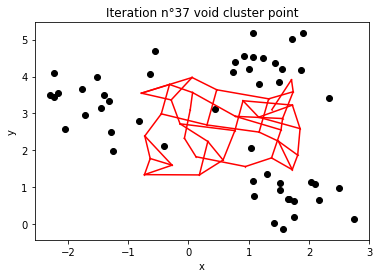

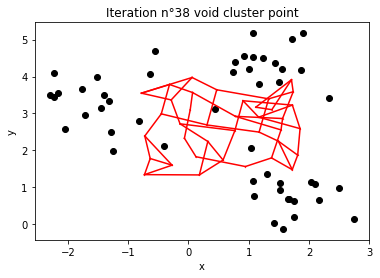

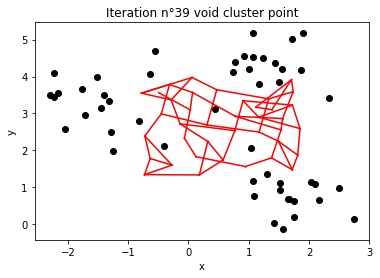

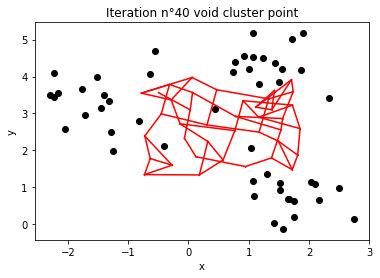

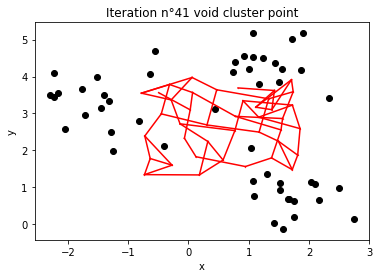

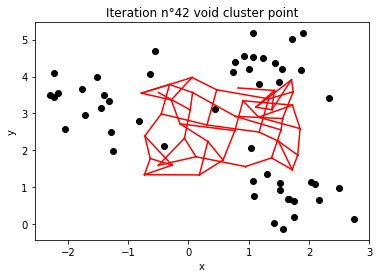

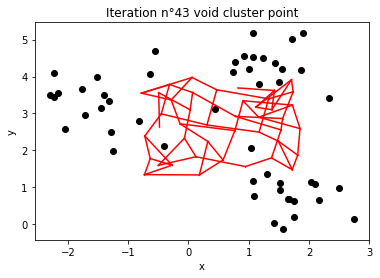

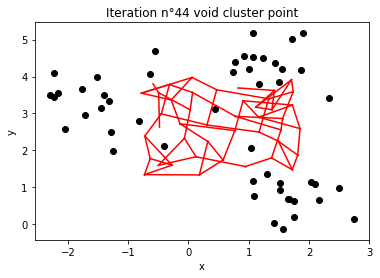

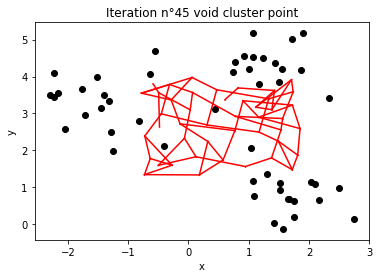

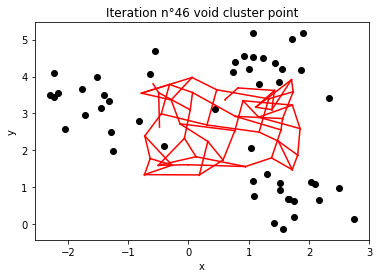

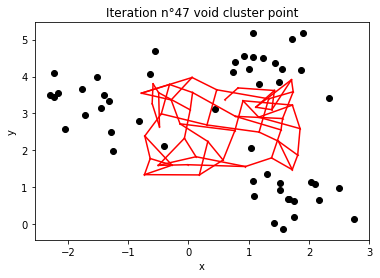

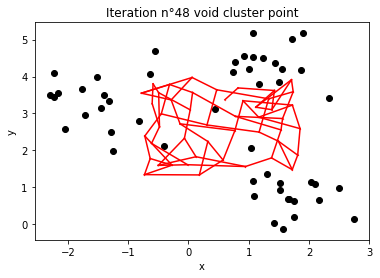

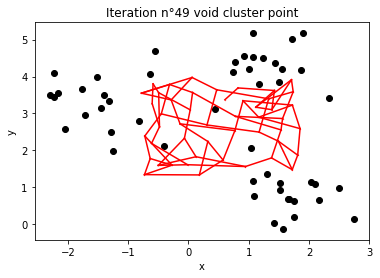

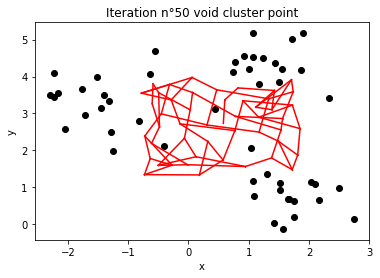

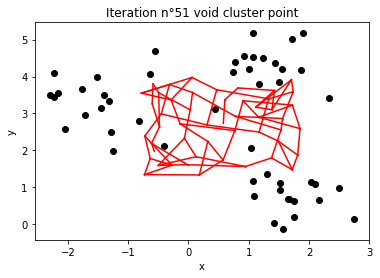

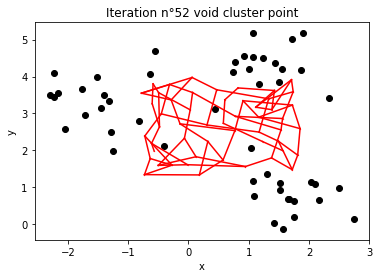

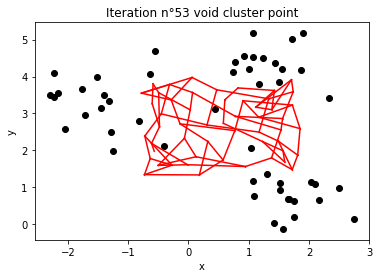

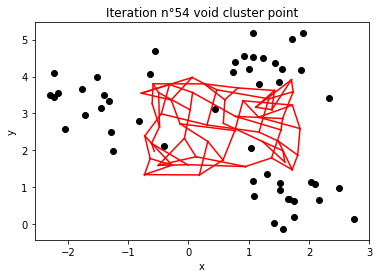

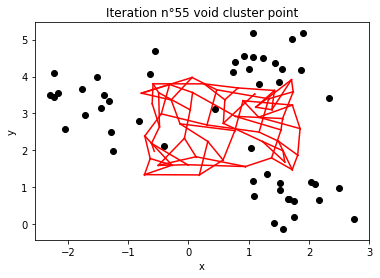

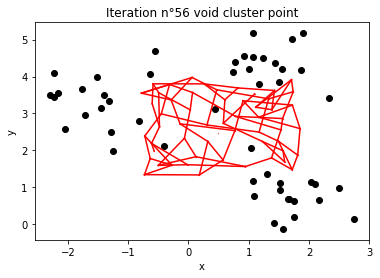

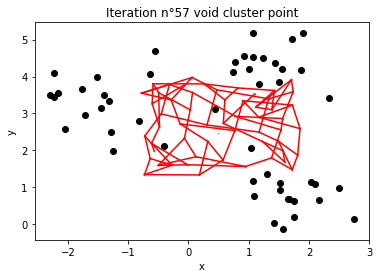

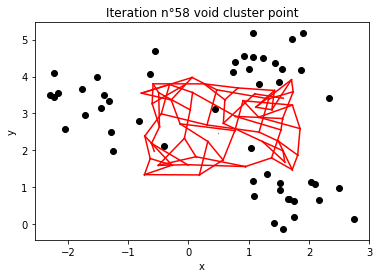

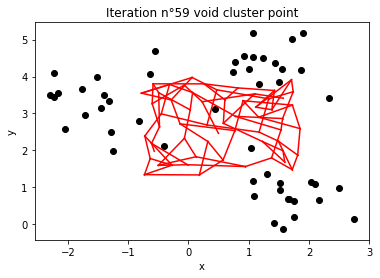

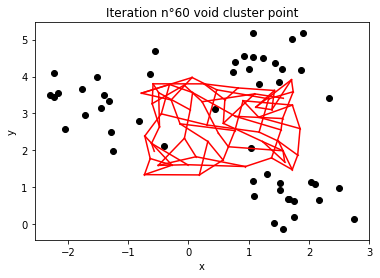

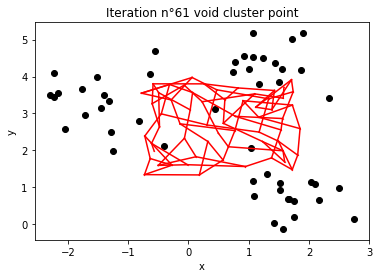

In [280]:
void_clustering(data=X)